In [2]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

## DAY 1: Generate the sp 500 datatable and create a sql dataset which updates daily at 2:00 AM

In [3]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-5-25'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

[*********************100%%**********************]  503 of 503 completed

2 Failed downloads:
['SW', 'AMTM']: YFChartError("%ticker%: Data doesn't exist for startDate = 1464321600, endDate = 1716609600")


In [4]:
df.head(1000)

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-05-27 A        42.917034   45.820000   45.849998   45.369999   45.549999   
           AAPL     23.015892   25.087500   25.117500   24.812500   24.860001   
           ABBV     43.688190   62.709999   63.200001   61.900002   61.990002   
           ABT      33.582714   39.299999   39.400002   38.919998   39.040001   
           ACGL     24.053333   24.053333   24.100000   23.830000   23.976667   
...                       ...         ...         ...         ...         ...   
2016-06-01 AXON     22.320000   22.320000   22.400000   21.980000   22.309999   
           AXP      58.388344   65.910004   65.959999   65.180000   65.760002   
           AZO     760.750000  760.750000  764.659973  758.400024  759.700012   
           BA      115.351128  126.410004  126.500000  124.779999  126.000000   
           BAC      12.368361   14.860000   14.900000   14.450000   14.600000   

Price                   volume  
date       ticker               
2016-05-27 A         1822700.0  
           AAPL    145364800.0  
           ABBV      5768000.0  
           ABT      12339400.0  
           ACGL       449400.0  
...                        ...  
2016-06-01 AXON       759700.0  
           AXP       3816000.0  
           AZO        327700.0  
           BA        4679600.0  
           BAC      62612100.0  

[1000 rows x 6 columns]

## Feature Engineering & Learning

### RSI, GKV, BB do not require standardization

## Interpretation of RSI
### RSI > 70: The asset is generally considered overbought and may be due for a price correction or pullback.
### RSI < 30: The asset is generally considered oversold and may be due for a price rebound or rally.
### RSI between 30 and 70: The asset is considered to be in a neutral range.

In [5]:
### grouby(level=1)here is grouped by price ticker

In [6]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

## Garman-Klass Volatility

### Garman-Klass volatility is a valuable feature in financial analysis and modeling due to its comprehensive approach to measuring daily volatility. By incorporating high, low, open, and close prices, it provides a more accurate and reliable estimate of volatility, which can improve risk management, trading strategies, and predictive models. Integrating GK volatility into your financial workflows can enhance the robustness and accuracy of your analysis and decision-making processes.

In [7]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

## Bollinger Bands
### Bollinger Bands are a type of statistical chart characterizing the prices and volatility over time of a financial instrument or commodity. They were developed by John Bollinger in the 1980s and are widely used in technical analysis to identify overbought or oversold conditions and to predict potential market reversals.



In [8]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

## ATRAverage True Range (ATR):

### The ATR is the moving average of the true range over a specified period, usually 14 days.


In [9]:
## transform works with only one column

In [10]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std()) ## standardize atr

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)


## Moving Average Convergence Divergence (MACD) indicator, the two moving averages referred to are:

### Short-term Exponential Moving Average (EMA):

This is typically the 12-period EMA, which reacts more quickly to recent price changes due to its shorter period.
It represents the short-term trend and highlights recent price movements more clearly.

### Long-term Exponential Moving Average (EMA):

This is usually the 26-period EMA, which reacts more slowly to price changes because it averages over a longer period.
It represents the long-term trend and smooths out more of the daily price fluctuations.

In [11]:
## iloc returns the first column, which is the MACD column,and this is because the package generates a dataframe

## Read the MACD Score
## Typical Value Ranges:

### -1 to 1: Most of the values (approximately 68% of data in a normal distribution) fall within one standard deviation of the mean. This range can be considered as the normal fluctuation around the mean.
### -2 to 2: Approximately 95% of the data in a normal distribution falls within two standard deviations of the mean. Values in this range are more significant but still within expected limits.
### Beyond -2 or 2: Values beyond two standard deviations from the mean are relatively rare (approximately 5% of the data in a normal distribution). These values indicate unusually strong movements and can be interpreted as strong bullish or bearish signals depending on the direction.

In [12]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)


## Dollar Volume

In [13]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

In [14]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-05-27 A        42.917034   45.820000   45.849998   45.369999   45.549999   
           AAPL     23.015892   25.087500   25.117500   24.812500   24.860001   
           ABBV     43.688190   62.709999   63.200001   61.900002   61.990002   
           ABT      33.582714   39.299999   39.400002   38.919998   39.040001   
           ACGL     24.053333   24.053333   24.100000   23.830000   23.976667   
...                       ...         ...         ...         ...         ...   
2024-05-24 XYL     143.492218  144.250000  145.089996  143.020004  144.779999   
           YUM     136.966583  137.649994  137.979996  136.690002  136.889999   
           ZBH     116.151840  116.410004  116.529999  115.440002  116.019997   
           ZBRA    327.000000  327.000000  327.000000  322.600006  325.309998   
           ZTS     169.265335  170.070007  172.270004  169.729996  171.570007   

Price                   volume        rsi  garman_klass_vol    bb_low  \
date       ticker                                                       
2016-05-27 A         1822700.0        NaN         -0.001314       NaN   
           AAPL    145364800.0        NaN         -0.002220       NaN   
           ABBV      5768000.0        NaN         -0.047077       NaN   
           ABT      12339400.0        NaN         -0.008683       NaN   
           ACGL       449400.0        NaN          0.000060       NaN   
...                        ...        ...               ...       ...   
2024-05-24 XYL       1477100.0  68.324279          0.000072  4.880871   
           YUM       1453200.0  50.569496          0.000044  4.891660   
           ZBH       1084200.0  38.190230          0.000044  4.766602   
           ZBRA       205400.0  63.851556          0.000081  5.723580   
           ZTS       1893800.0  53.373276          0.000040  5.070551   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-05-27 A            NaN       NaN       NaN       NaN      78.224878  
           AAPL         NaN       NaN       NaN       NaN    3345.700542  
           ABBV         NaN       NaN       NaN       NaN     251.993483  
           ABT          NaN       NaN       NaN       NaN     414.390542  
           ACGL         NaN       NaN       NaN       NaN      10.809568  
...                     ...       ...       ...       ...            ...  
2024-05-24 XYL     4.947062  5.013253  0.315464  2.001636     211.952355  
           YUM     4.925517  4.959374  0.423962 -0.072034     199.039839  
           ZBH     4.793027  4.819451 -0.741663 -0.619564     125.931825  
           ZBRA    5.763489  5.803398 -0.192162  0.925236      67.165800  
           ZTS     5.126644  5.182737  0.659626  0.943331     320.554692  

[986557 rows x 14 columns]

## Monthly Level

In [15]:
df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

dollar_volume
date       ticker               
2016-05-31 A           87.605392
           AAPL      3610.816309
           ABBV       282.683877
           ABT        476.199609
           ACGL        37.978261
...                          ...
2024-05-31 GEHC       178.537591
           KVUE       566.156145
           VLTO       122.454909
           GEV        513.936231
           SOLV       116.042326

[47560 rows x 1 columns]

In [16]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]


In [17]:
df.unstack()[last_cols].resample('M').last().stack('ticker')

Price               adj close        rsi  garman_klass_vol    bb_low  \
date       ticker                                                      
2016-05-31 A        42.982586        NaN         -0.001504       NaN   
           AAPL     22.903502        NaN         -0.002573       NaN   
           ABBV     43.841446        NaN         -0.049402       NaN   
           ABT      33.864712        NaN         -0.008557       NaN   
           ACGL     24.219999        NaN          0.000064       NaN   
...                       ...        ...               ...       ...   
2024-05-31 XYL     143.492218  68.324279          0.000072  4.880871   
           YUM     136.966583  50.569496          0.000044  4.891660   
           ZBH     116.151840  38.190230          0.000044  4.766602   
           ZBRA    327.000000  63.851556          0.000081  5.723580   
           ZTS     169.265335  53.373276          0.000040  5.070551   

Price                bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-05-31 A            NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
           ACGL         NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2024-05-31 XYL     4.947062  5.013253  0.315464  2.001636  
           YUM     4.925517  4.959374  0.423962 -0.072034  
           ZBH     4.793027  4.819451 -0.741663 -0.619564  
           ZBRA    5.763489  5.803398 -0.192162  0.925236  
           ZTS     5.126644  5.182737  0.659626  0.943331  

[47560 rows x 8 columns]

In [18]:
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                         df.unstack()[last_cols].resample('M').last().stack('ticker')],axis=1)).dropna()
data

dollar_volume   adj close        rsi  garman_klass_vol  \
date       ticker                                                           
2016-07-31 A           75.326375   45.180668  63.954690         -0.000813   
           AAPL      3114.531043   23.901205  66.365608         -0.002822   
           ABBV       344.203967   46.545528  66.422400         -0.043978   
           ABT        399.475953   38.475418  76.686218         -0.007689   
           ACGL        23.599968   24.209999  60.110611          0.000062   
...                          ...         ...        ...               ...   
2024-05-31 GEHC       178.537591   79.794052  42.985969          0.000144   
           KVUE       566.156145   19.164118  44.843880          0.000133   
           VLTO       122.454909  102.013206  70.865516          0.000171   
           GEV        513.936231  177.429993  66.805901          0.001407   
           SOLV       116.042326   60.450001  40.147607          0.000368   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-07-31 A       3.744916  3.793227  3.841538 -1.318861  0.089020  
           AAPL    3.109891  3.161109  3.212326 -1.213716 -0.118666  
           ABBV    3.792731  3.824890  3.857048 -1.323269  0.131534  
           ABT     3.552550  3.618989  3.685429 -1.215132  0.735724  
           ACGL    3.172223  3.197355  3.222488 -1.156613 -0.255609  
...                     ...       ...       ...       ...       ...  
2024-05-31 GEHC    4.345471  4.405168  4.464866 -0.171266 -1.012915  
           KVUE    2.954398  3.024396  3.094394 -0.625089  0.751369  
           VLTO    4.540332  4.585968  4.631604 -0.560987  1.297798  
           GEV     5.031931  5.102452  5.172973  0.012120 -1.276799  
           SOLV    4.108238  4.167201  4.226163 -1.706479 -1.728575  

[46581 rows x 9 columns]

In [19]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
data

dollar_volume   adj close        rsi  garman_klass_vol  \
date       ticker                                                           
2016-07-31 A                 NaN   45.180668  63.954690         -0.000813   
           AAPL              NaN   23.901205  66.365608         -0.002822   
           ABBV              NaN   46.545528  66.422400         -0.043978   
           ABT               NaN   38.475418  76.686218         -0.007689   
           ACGL              NaN   24.209999  60.110611          0.000062   
...                          ...         ...        ...               ...   
2024-05-31 GEHC       231.358399   79.794052  42.985969          0.000144   
           KVUE       477.160585   19.164118  44.843880          0.000133   
           VLTO              NaN  102.013206  70.865516          0.000171   
           GEV               NaN  177.429993  66.805901          0.001407   
           SOLV              NaN   60.450001  40.147607          0.000368   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-07-31 A       3.744916  3.793227  3.841538 -1.318861  0.089020  
           AAPL    3.109891  3.161109  3.212326 -1.213716 -0.118666  
           ABBV    3.792731  3.824890  3.857048 -1.323269  0.131534  
           ABT     3.552550  3.618989  3.685429 -1.215132  0.735724  
           ACGL    3.172223  3.197355  3.222488 -1.156613 -0.255609  
...                     ...       ...       ...       ...       ...  
2024-05-31 GEHC    4.345471  4.405168  4.464866 -0.171266 -1.012915  
           KVUE    2.954398  3.024396  3.094394 -0.625089  0.751369  
           VLTO    4.540332  4.585968  4.631604 -0.560987  1.297798  
           GEV     5.031931  5.102452  5.172973  0.012120 -1.276799  
           SOLV    4.108238  4.167201  4.226163 -1.706479 -1.728575  

[46581 rows x 9 columns]

In [20]:
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close        rsi  garman_klass_vol    bb_low  \
date       ticker                                                      
2017-06-30 AAPL     33.664440  43.606704         -0.001870  3.514581   
           ABBV     52.464611  71.506071         -0.040620  3.908227   
           ABT      42.590485  67.057478         -0.007072  3.724904   
           ACN     110.406380  49.971707         -0.004662  4.695359   
           ADBE    141.440002  54.196890          0.000103  4.922309   
...                       ...        ...               ...       ...   
2024-05-31 UBER     64.260002  39.570367          0.000136  4.155078   
           CRWD    351.470001  64.731428          0.000672  5.670065   
           PLTR     21.010000  45.110281          0.000212  3.038506   
           ABNB    144.470001  40.413485          0.000251  4.931056   
           KVUE     19.164118  44.843880          0.000133  2.954398   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-06-30 AAPL    3.566479  3.618377 -1.081656 -0.449877  
           ABBV    3.955802  4.003377 -1.525846  0.403945  
           ABT     3.762458  3.800012 -1.328072  0.466947  
           ACN     4.726683  4.758007 -1.092398 -0.202202  
           ADBE    4.958985  4.995660 -1.198709 -0.021283  
...                     ...       ...       ...       ...  
2024-05-31 UBER    4.214757  4.274436  0.864299 -1.547919  
           CRWD    5.785653  5.901241  0.802003  1.496118  
           PLTR    3.125634  3.212762 -0.265068 -0.482432  
           ABNB    5.023231  5.115407 -0.957451 -1.000960  
           KVUE    3.024396  3.094394 -0.625089  0.751369  

[12516 rows x 8 columns]

In [21]:
### df.xs is a powerful method for extracting specific cross-sections of data from MultiIndex DataFrames

## Monthly Returns

In [22]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close        rsi  garman_klass_vol    bb_low  \
date       ticker                                                      
2018-06-30 AAPL     43.941765  49.582347         -0.001039  3.785642   
           ABBV     69.310486  38.080545         -0.032794  4.234164   
           ABT      54.515362  47.018507         -0.005479  4.007592   
           ACN     148.748642  58.053417         -0.003650  4.962355   
           ADBE    243.809998  50.937236          0.000110  5.474781   
...                       ...        ...               ...       ...   
2024-05-31 MRNA    166.610001  81.662308          0.001177  4.634902   
           UBER     64.260002  39.570367          0.000136  4.155078   
           CRWD    351.470001  64.731428          0.000672  5.670065   
           PLTR     21.010000  45.110281          0.000212  3.038506   
           ABNB    144.470001  40.413485          0.000251  4.931056   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-06-30 AAPL    3.823149  3.860657 -1.021954 -0.315160  -0.009418   
           ABBV    4.296758  4.359351 -0.280046 -1.216535  -0.063574   
           ABT     4.037351  4.067111 -0.957219 -0.327911  -0.008776   
           ACN     4.994140  5.025926 -0.629403  0.030994   0.050404   
           ADBE    5.521728  5.568676 -0.707753 -0.176526  -0.021943   
...                     ...       ...       ...       ...        ...   
2024-05-31 MRNA    4.874040  5.113179 -0.076924  1.393266   0.510380   
           UBER    4.214757  4.274436  0.864299 -1.547919  -0.030330   
           CRWD    5.785653  5.901241  0.802003  1.496118   0.201443   
           PLTR    3.125634  3.212762 -0.265068 -0.482432  -0.043696   
           ABNB    5.023231  5.115407 -0.957451 -1.000960  -0.088920   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-06-30 AAPL     0.060393   0.034635   0.016401   0.021872    0.022450  
           ABBV    -0.020405  -0.003677  -0.004230   0.007379    0.023476  
           ABT      0.024305   0.007529   0.012748   0.016592    0.020784  
           ACN      0.040166   0.024443   0.012599   0.023607    0.025152  
           ADBE     0.048916   0.041068   0.056582   0.056099    0.046421  
...                      ...        ...        ...        ...         ...  
2024-05-31 MRNA     0.250413   0.217850   0.135569   0.044013    0.022405  
           UBER    -0.086406  -0.068482   0.022043   0.034804    0.044912  
           CRWD     0.047054   0.027340   0.067890   0.089103    0.067705  
           PLTR    -0.044447  -0.057316   0.007825   0.038302    0.030152  
           ABNB    -0.064165  -0.028313   0.022601   0.010464    0.023154  

[10361 rows x 14 columns]

## Fama French Factor

In [23]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-06-30 AAPL    0.0048  0.0080 -0.0233  0.0080  0.0020  -0.009418
           ABBV    0.0048  0.0080 -0.0233  0.0080  0.0020  -0.063574
           ABT     0.0048  0.0080 -0.0233  0.0080  0.0020  -0.008776
           ACN     0.0048  0.0080 -0.0233  0.0080  0.0020   0.050404
           ADBE    0.0048  0.0080 -0.0233  0.0080  0.0020  -0.021943
...                   ...     ...     ...     ...     ...        ...
2024-05-31 VRTX    0.0434  0.0076 -0.0166  0.0298 -0.0307   0.163285
           VZ      0.0434  0.0076 -0.0166  0.0298 -0.0307   0.006331
           WFC     0.0434  0.0076 -0.0166  0.0298 -0.0307   0.020839
           WMT     0.0434  0.0076 -0.0166  0.0298 -0.0307   0.105414
           XOM     0.0434  0.0076 -0.0166  0.0298 -0.0307  -0.033218

[10361 rows x 6 columns]

In [24]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-06-30 AAPL    0.0048  0.0080 -0.0233  0.0080  0.0020  -0.009418
           ABBV    0.0048  0.0080 -0.0233  0.0080  0.0020  -0.063574
           ABT     0.0048  0.0080 -0.0233  0.0080  0.0020  -0.008776
           ACN     0.0048  0.0080 -0.0233  0.0080  0.0020   0.050404
           ADBE    0.0048  0.0080 -0.0233  0.0080  0.0020  -0.021943
...                   ...     ...     ...     ...     ...        ...
2024-05-31 VRTX    0.0434  0.0076 -0.0166  0.0298 -0.0307   0.163285
           VZ      0.0434  0.0076 -0.0166  0.0298 -0.0307   0.006331
           WFC     0.0434  0.0076 -0.0166  0.0298 -0.0307   0.020839
           WMT     0.0434  0.0076 -0.0166  0.0298 -0.0307   0.105414
           XOM     0.0434  0.0076 -0.0166  0.0298 -0.0307  -0.033218

[10308 rows x 6 columns]

In [25]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-06-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-05-31 VRTX    0.392874  0.790256 -0.594422  0.661607  0.510721
           VZ      0.472134 -0.892789  0.224092  0.138463  0.110637
           WFC     1.080610  0.181635  1.308757 -0.620247 -0.788905
           WMT     0.569787 -0.029707 -0.008721  0.753944  0.010970
           XOM     0.786291 -0.131365  0.441426  0.667608  0.578085

[10308 rows x 5 columns]

In [26]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10172 entries, (Timestamp('2018-06-30 00:00:00'), 'AAPL') to (Timestamp('2024-05-31 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rsi               10172 non-null  float64
 1   garman_klass_vol  10172 non-null  float64
 2   bb_low            10172 non-null  float64
 3   bb_mid            10172 non-null  float64
 4   bb_high           10172 non-null  float64
 5   atr               10172 non-null  float64
 6   macd              10172 non-null  float64
 7   return_1m         10172 non-null  float64
 8   return_2m         10172 non-null  float64
 9   return_3m         10172 non-null  float64
 10  return_6m         10172 non-null  float64
 11  return_9m         10172 non-null  float64
 12  return_12m        10172 non-null  float64
 13  Mkt-RF            10172 non-null  float64
 14  SMB               10172 non-null  float64
 15  HML      

## K Mean

In [27]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 0] = target_rsi_values

initial_centroids

array([[30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

### If the initialization of the cluster is random, when we produce the plots, the cluster colors and labels will be all over the places, however, we want to classify the rsi over 70 into one cluster therefore we define them/

In [28]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

rsi  garman_klass_vol    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-06-30 AAPL    49.582347         -0.001039  3.785642  3.823149  3.860657   
           ABBV    38.080545         -0.032794  4.234164  4.296758  4.359351   
           ABT     47.018507         -0.005479  4.007592  4.037351  4.067111   
           ACN     58.053417         -0.003650  4.962355  4.994140  5.025926   
           ADBE    50.937236          0.000110  5.474781  5.521728  5.568676   
...                      ...               ...       ...       ...       ...   
2024-05-31 WMT     70.700008          0.000054  4.056850  4.132908  4.208965   
           XOM     43.192372         -0.000002  4.729848  4.759172  4.788496   
           MRNA    81.662308          0.001177  4.634902  4.874040  5.113179   
           UBER    39.570367          0.000136  4.155078  4.214757  4.274436   
           CRWD    64.731428          0.000672  5.670065  5.785653  5.901241   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-06-30 AAPL   -1.021954 -0.315160  -0.009418   0.060393   0.034635   
           ABBV   -0.280046 -1.216535  -0.063574  -0.020405  -0.003677   
           ABT    -0.957219 -0.327911  -0.008776   0.024305   0.007529   
           ACN    -0.629403  0.030994   0.050404   0.040166   0.024443   
           ADBE   -0.707753 -0.176526  -0.021943   0.048916   0.041068   
...                     ...       ...        ...        ...        ...   
2024-05-31 WMT     1.278602  2.671543   0.105414   0.044198   0.039482   
           XOM     0.661316 -0.382637  -0.033218  -0.008201   0.030389   
           MRNA   -0.076924  1.393266   0.510380   0.250413   0.217850   
           UBER    0.864299 -1.547919  -0.030330  -0.086406  -0.068482   
           CRWD    0.802003  1.496118   0.201443   0.047054   0.027340   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-06-30 AAPL     0.016401   0.021872    0.022450  1.318744 -0.339990   
           ABBV    -0.004230   0.007379    0.023476  0.469577  0.521687   
           ABT      0.012748   0.016592    0.020784  0.794872 -0.129357   
           ACN      0.012599   0.023607    0.025152  1.213080 -0.184922   
           ADBE     0.056582   0.056099    0.046421  1.237833 -0.460957   
...                      ...        ...         ...       ...       ...   
2024-05-31 WMT      0.041075   0.022248    0.024798  0.611824  0.135569   
           XOM      0.019562   0.005158    0.011648  0.787324 -0.104920   
           MRNA     0.135569   0.044013    0.022405  1.187359  1.215081   
           UBER     0.022043   0.034804    0.044912  1.587959  0.223383   
           CRWD     0.067890   0.089103    0.067705  0.698897 -1.604370   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-06-30 AAPL   -0.614124  0.433678  0.587581        2  
           ABBV   -0.195499  0.516529  0.448490        0  
           ABT    -0.456537  0.253447  0.951148        1  
           ACN    -0.257692  0.325430  0.090987        2  
           ADBE   -0.209999  0.164588 -0.519425        2  
...                     ...       ...       ...      ...  
2024-05-31 WMT    -0.682852  0.605305  0.491637        3  
           XOM     0.679323  0.879338  0.322460        1  
           MRNA   -0.189108  1.584813  1.009037        3  
           UBER   -0.869821 -2.550926 -0.129851        0  
           CRWD    0.506888 -3.000495 -2.384835        3  

[10172 rows x 19 columns]

In [29]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,6] , cluster_0.iloc[:,0] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,6] , cluster_1.iloc[:,0] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,6] , cluster_2.iloc[:,0] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,6] , cluster_3.iloc[:,0] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

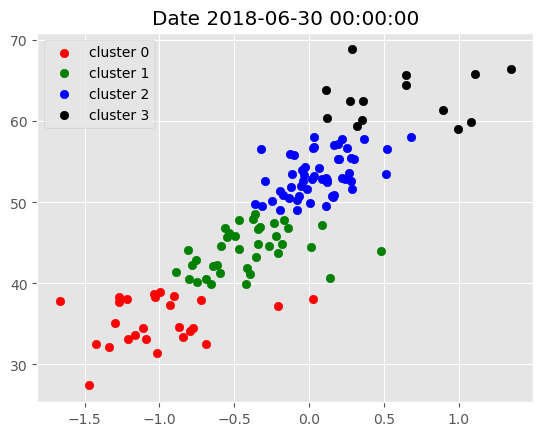

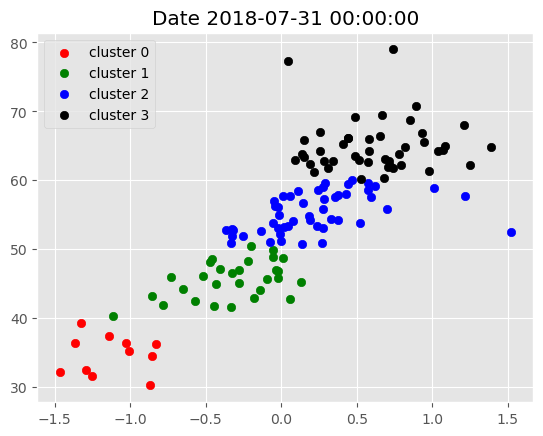

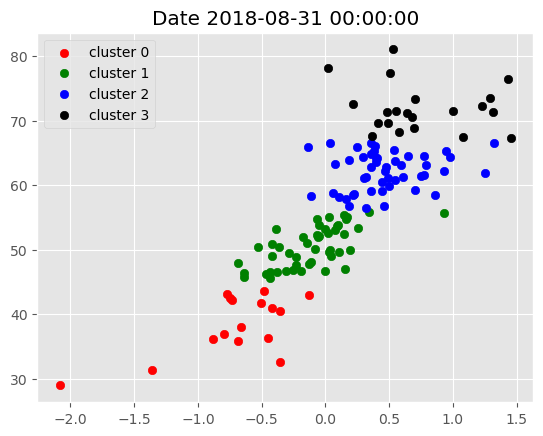

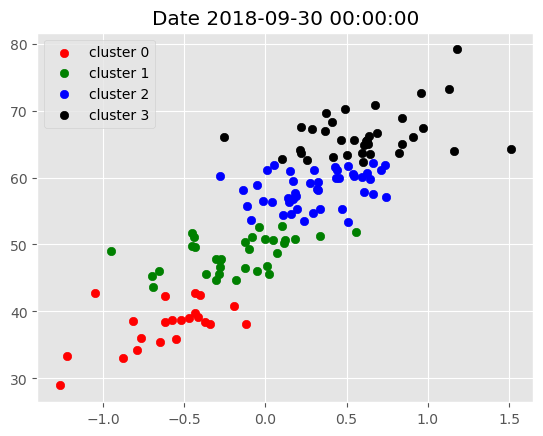

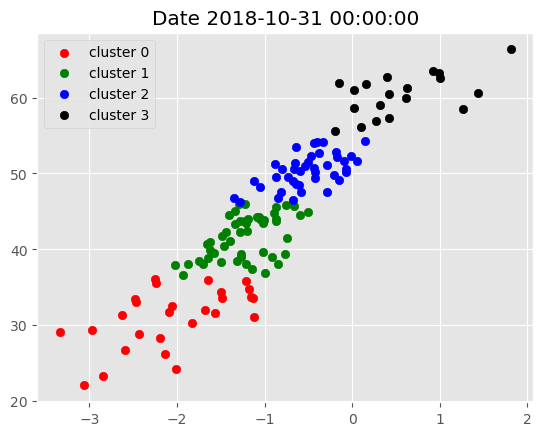

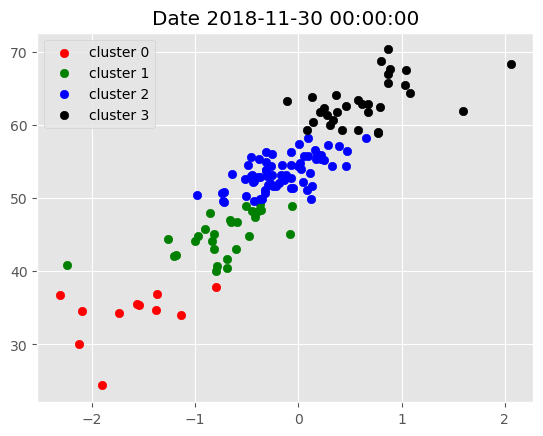

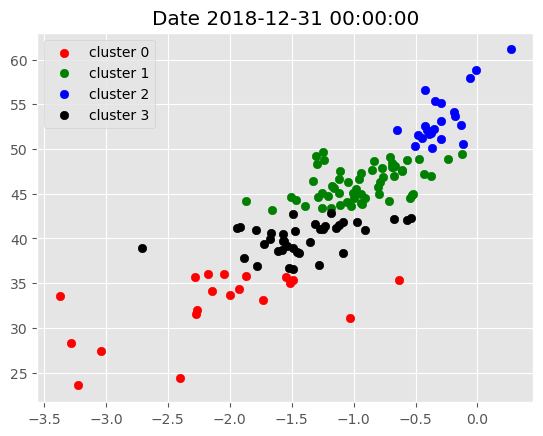

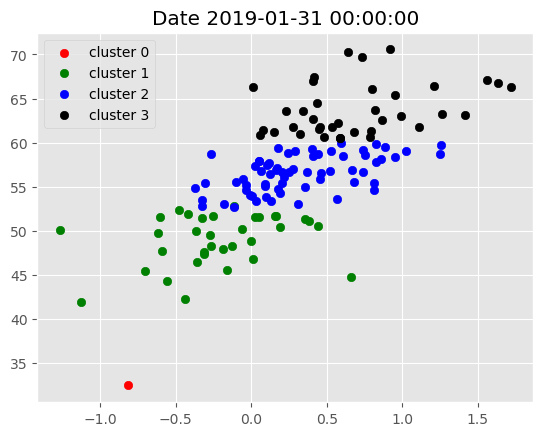

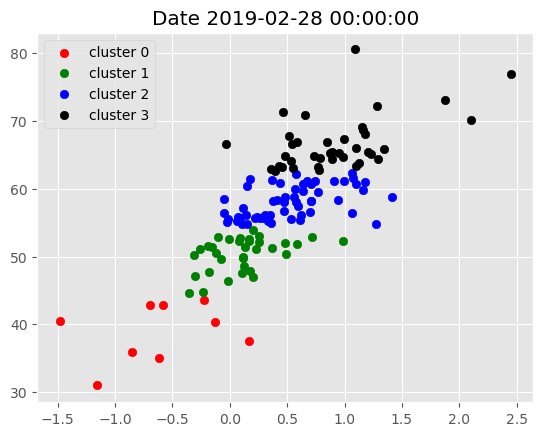

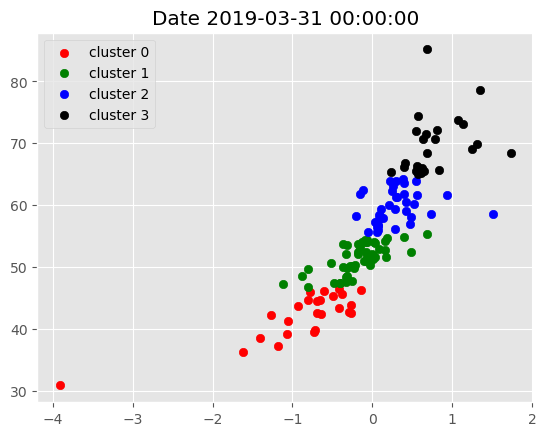

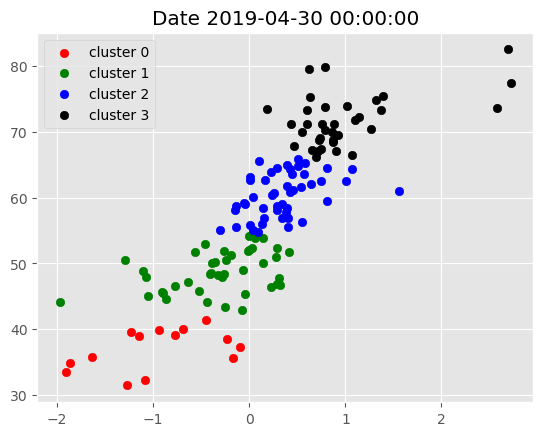

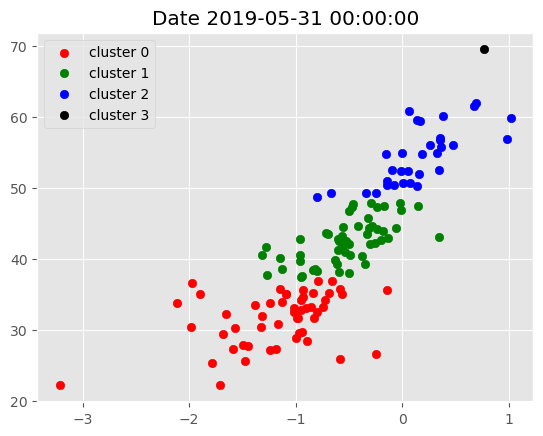

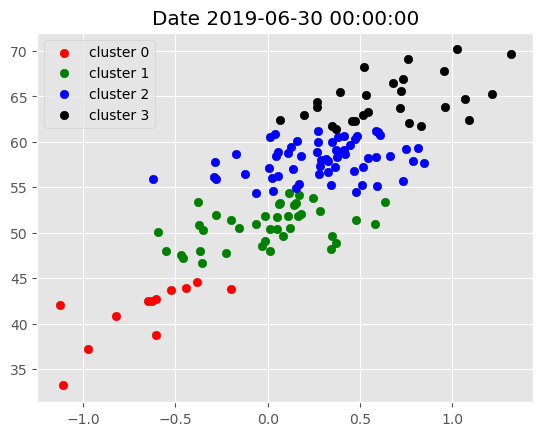

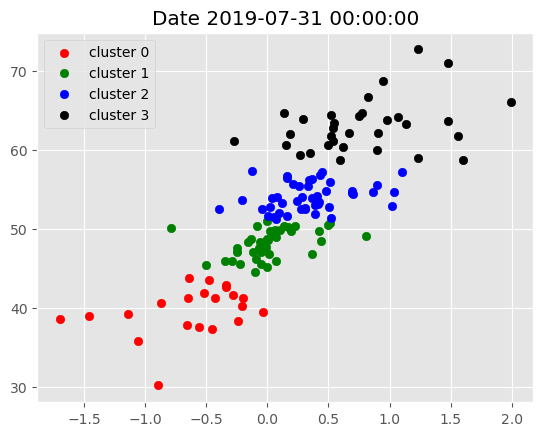

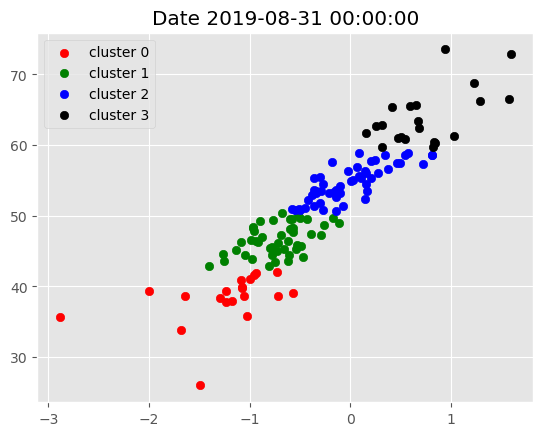

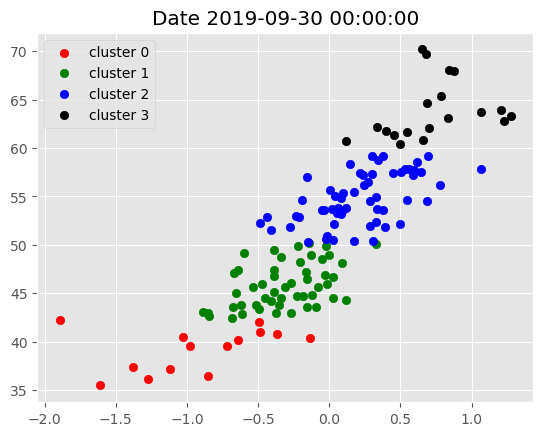

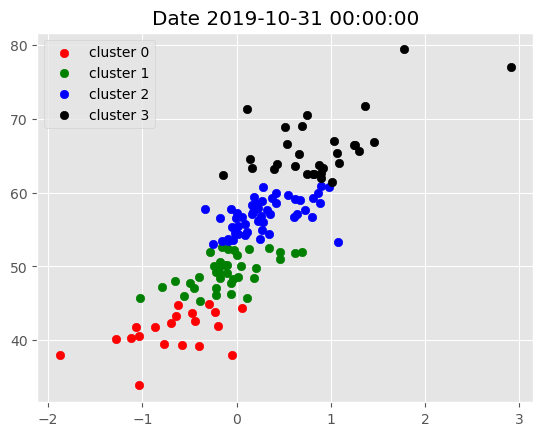

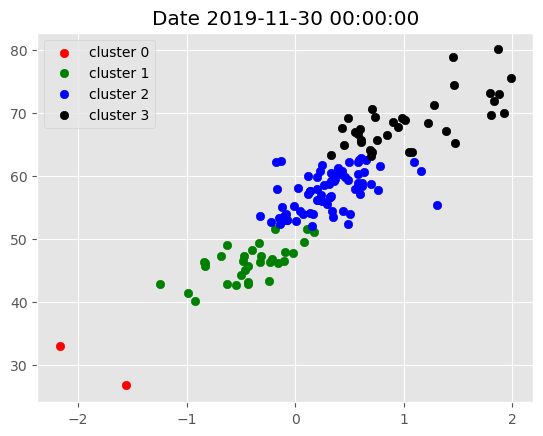

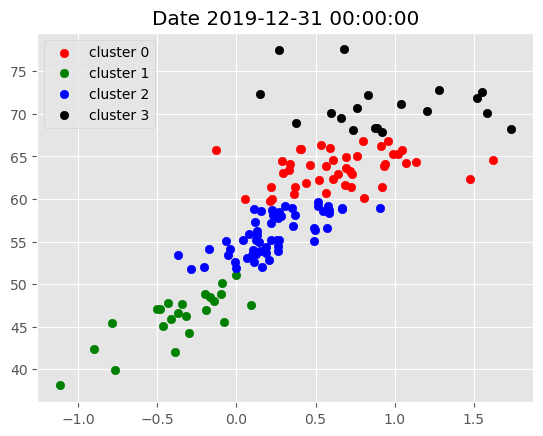

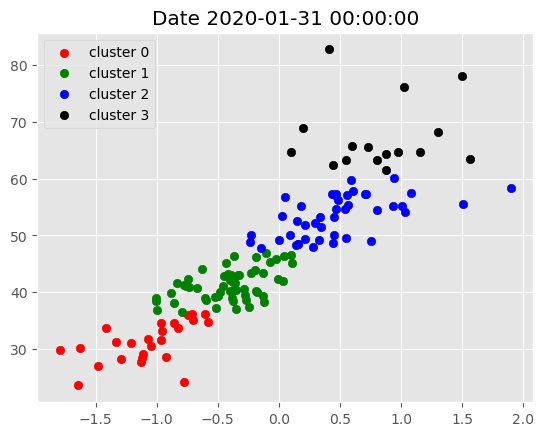

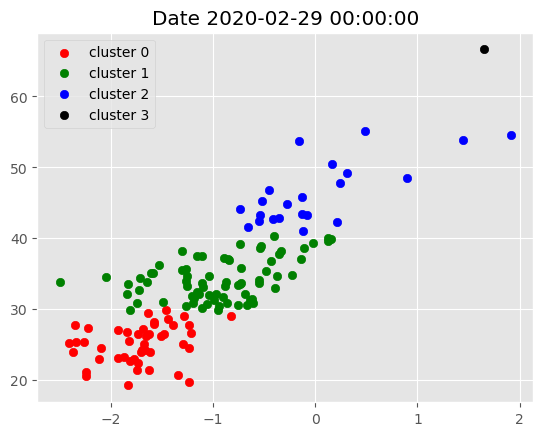

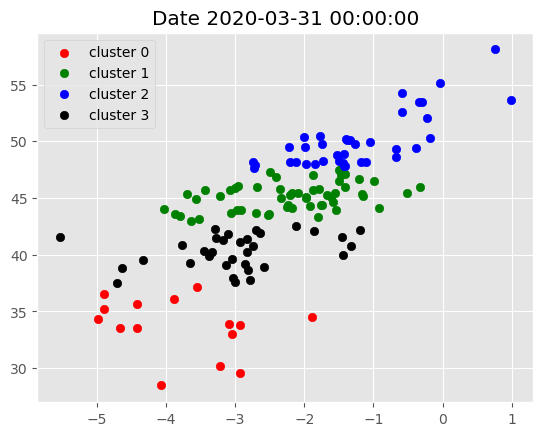

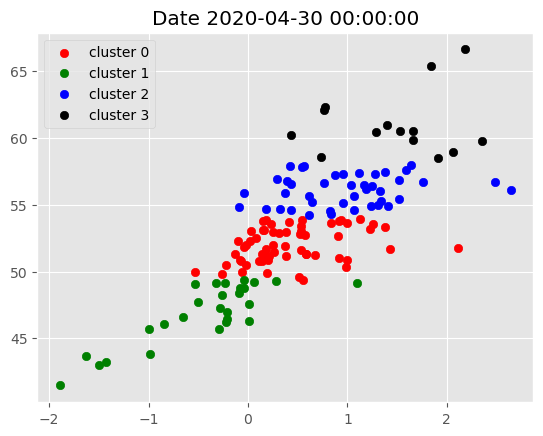

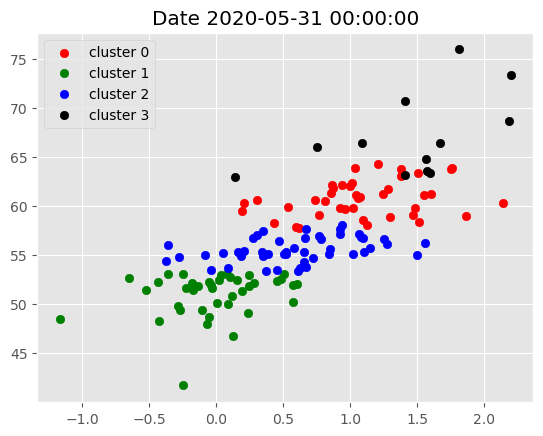

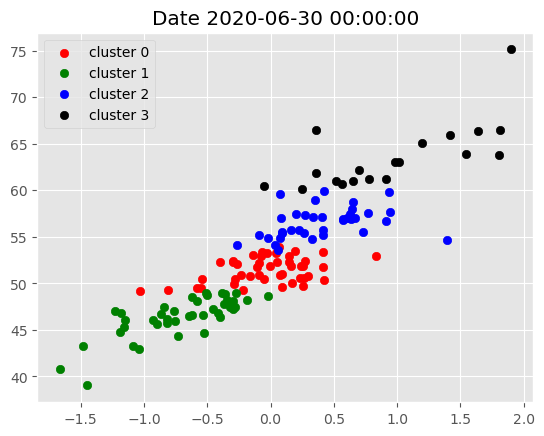

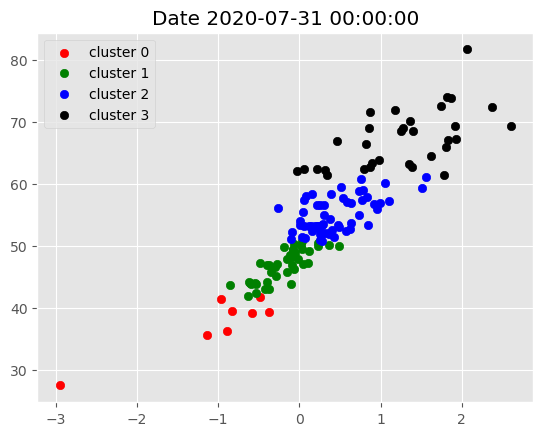

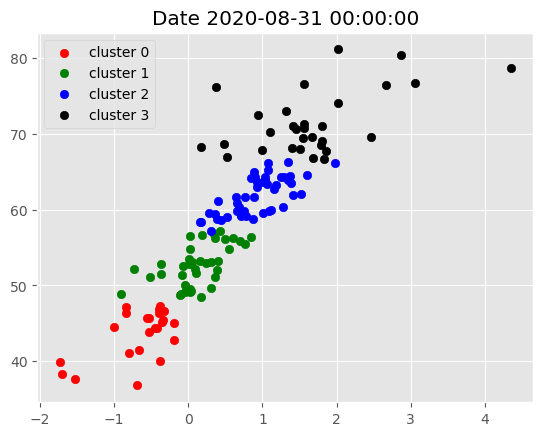

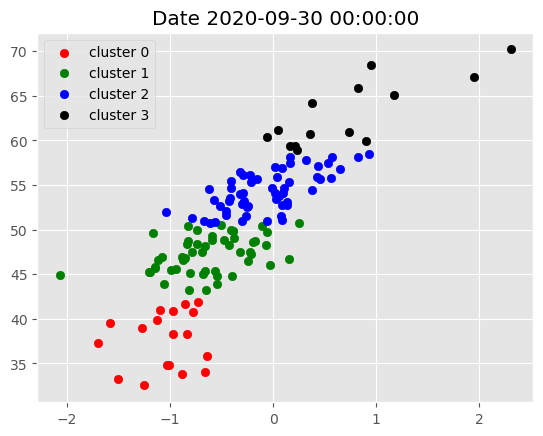

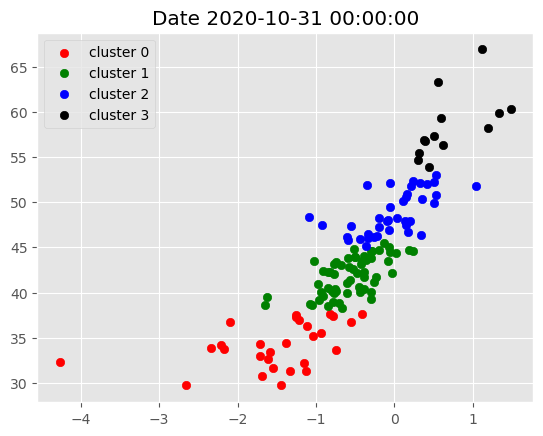

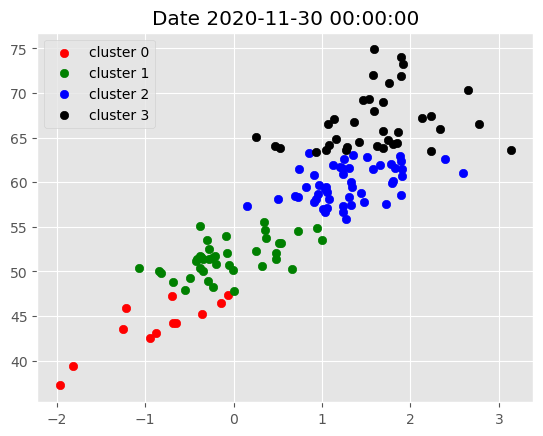

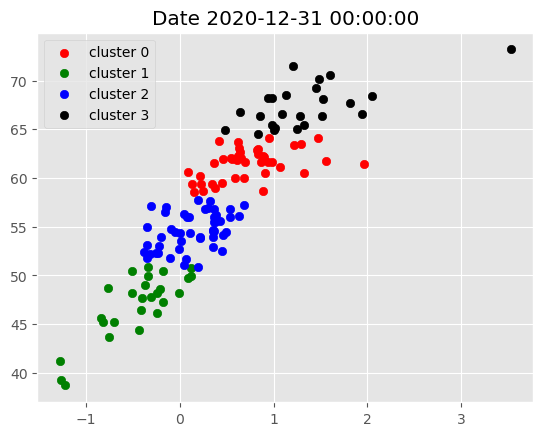

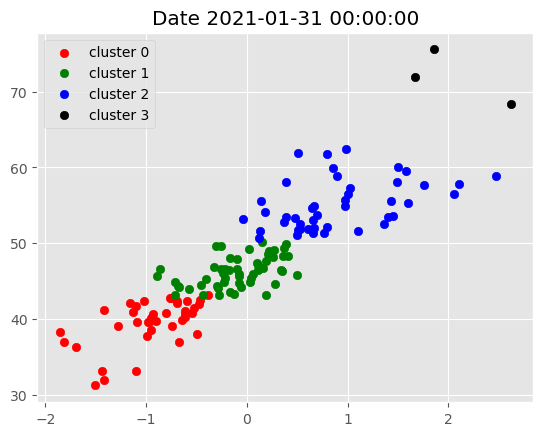

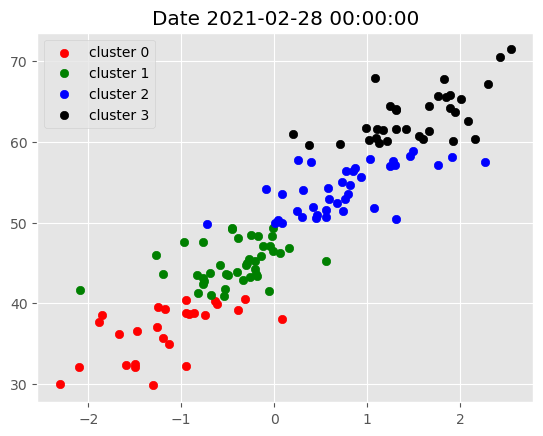

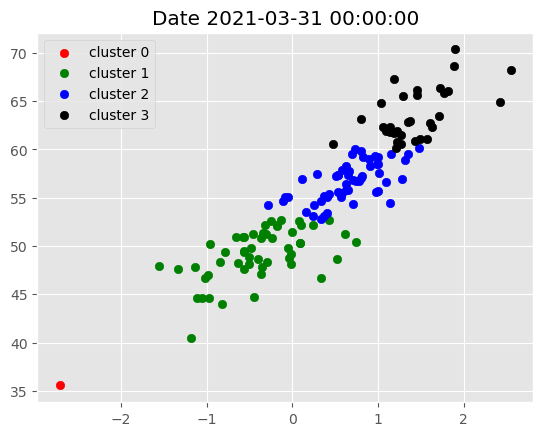

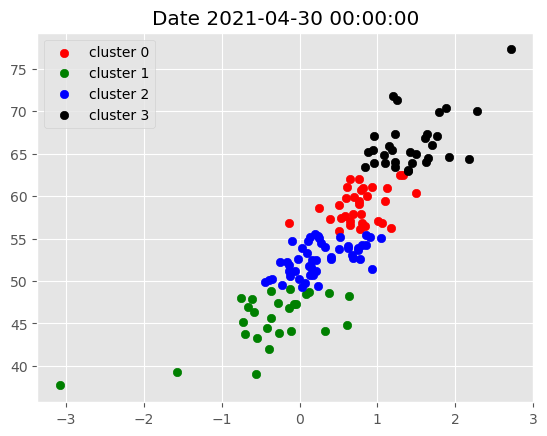

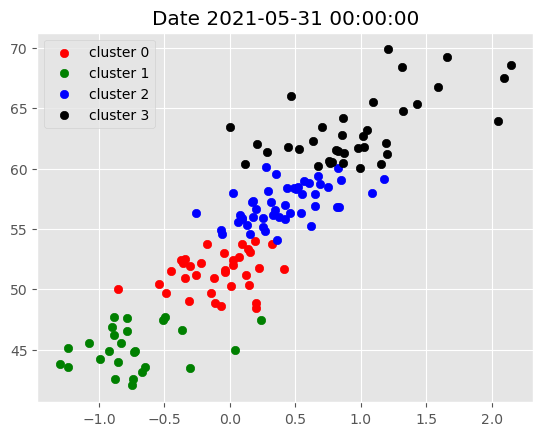

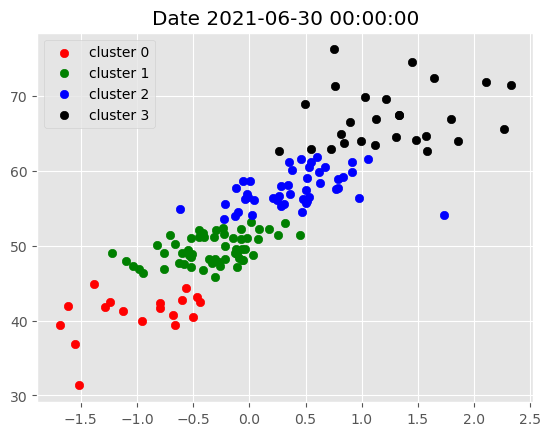

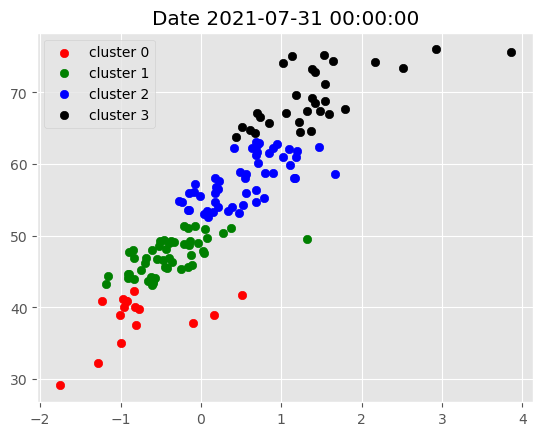

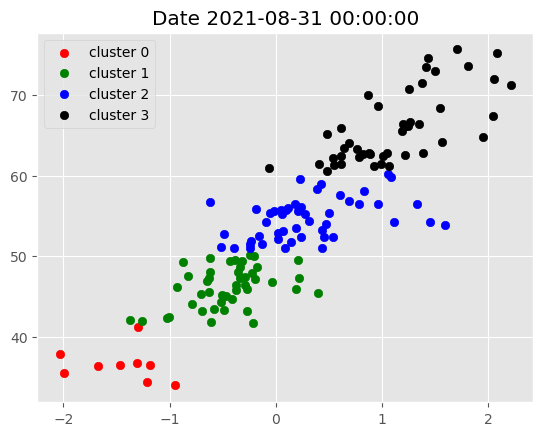

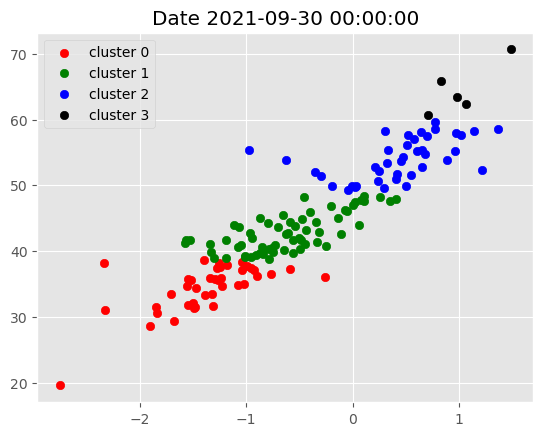

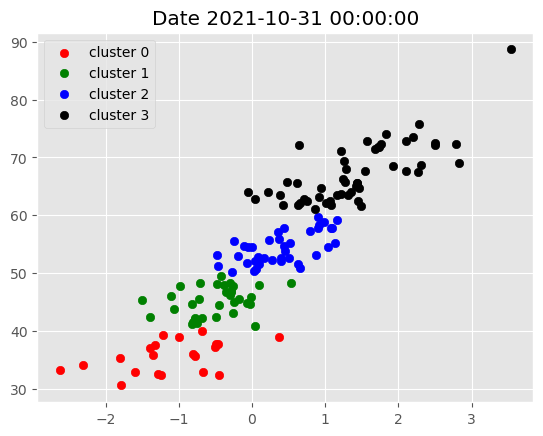

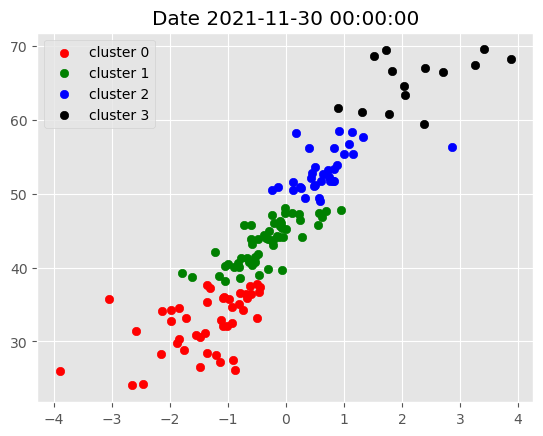

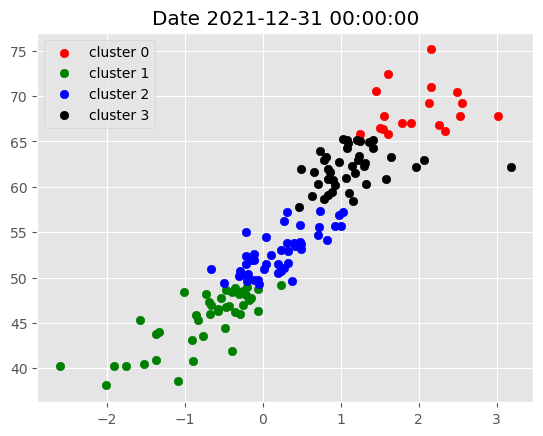

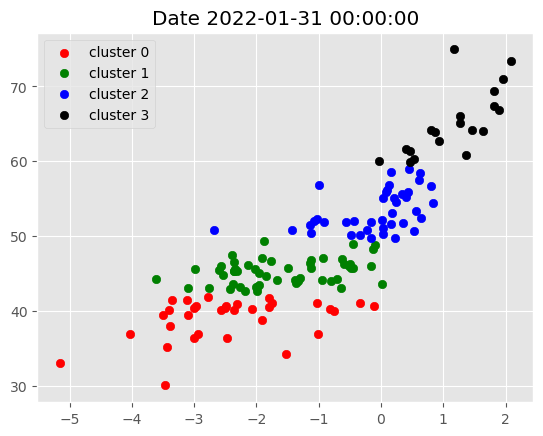

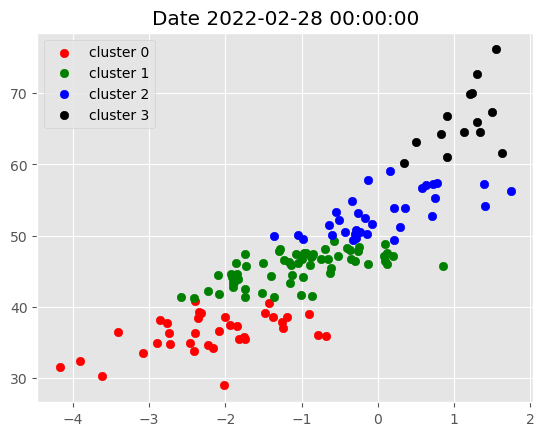

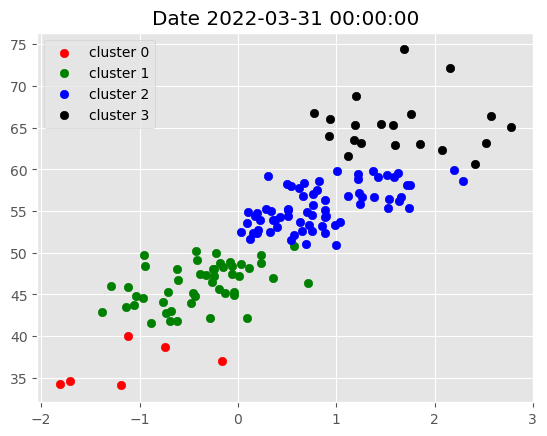

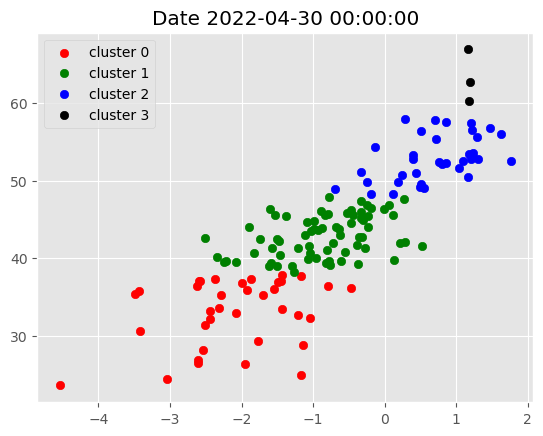

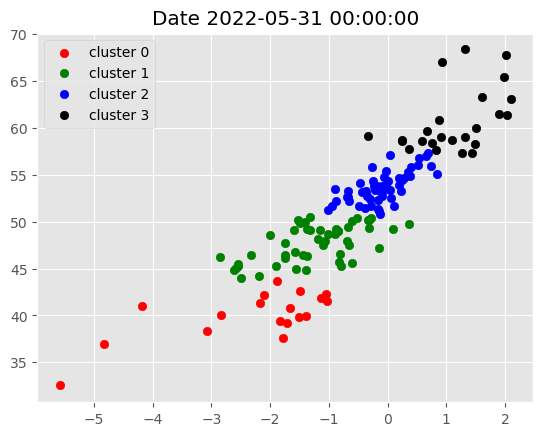

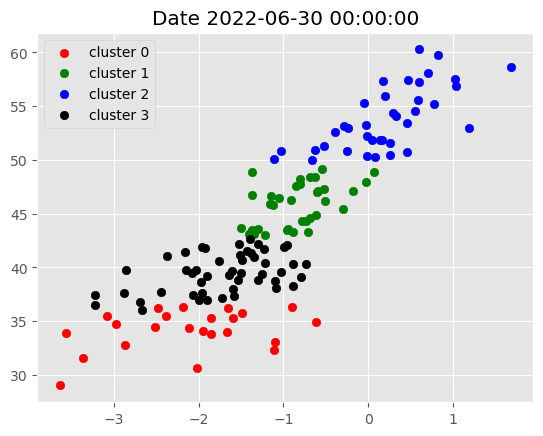

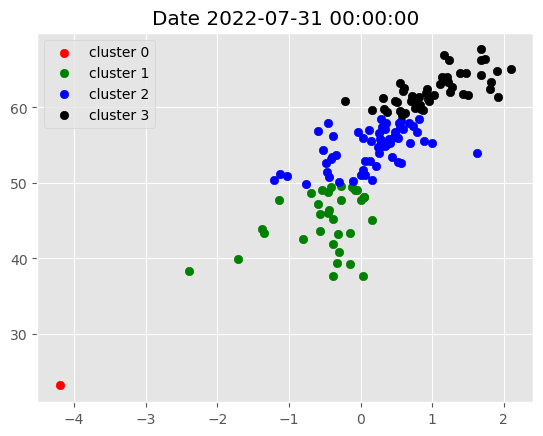

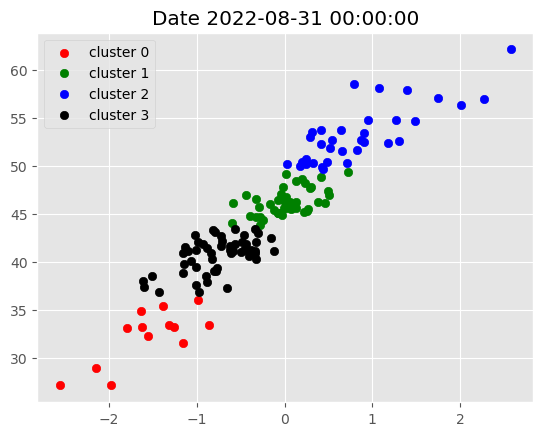

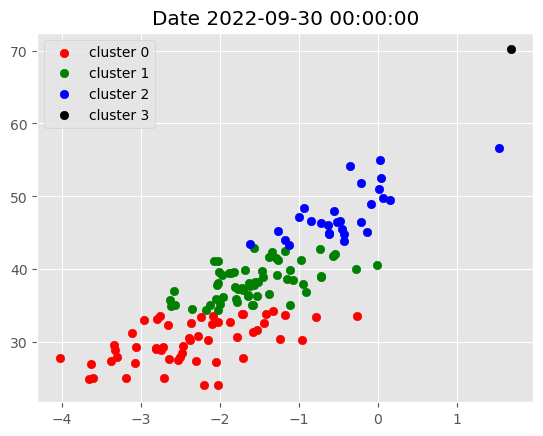

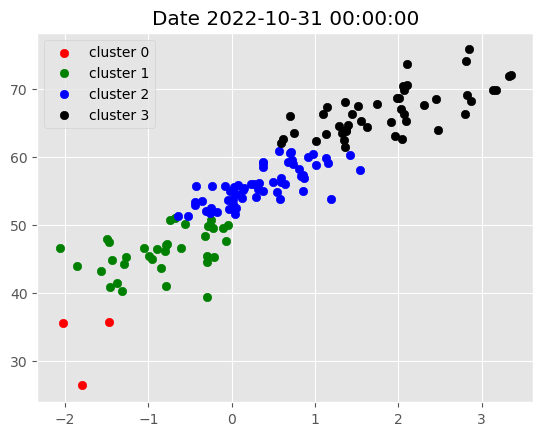

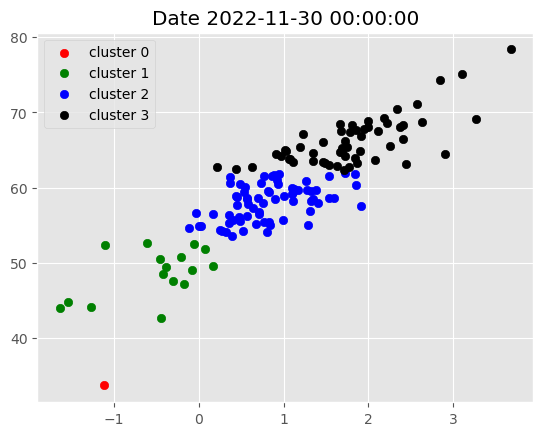

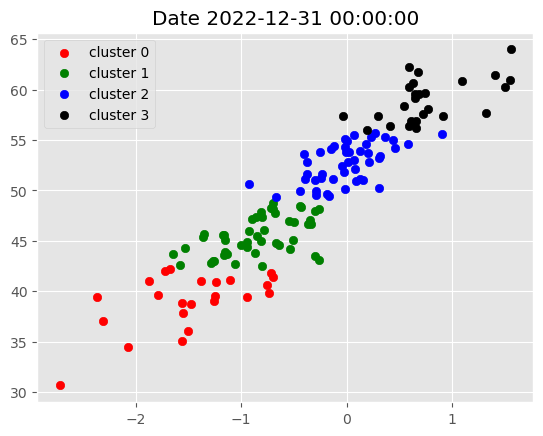

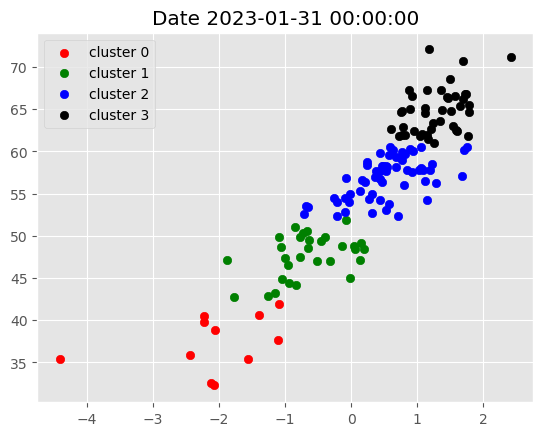

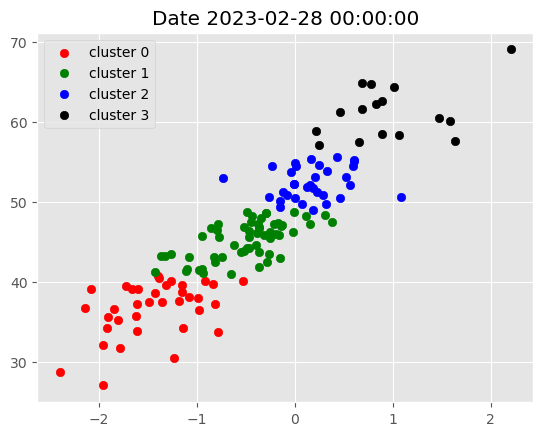

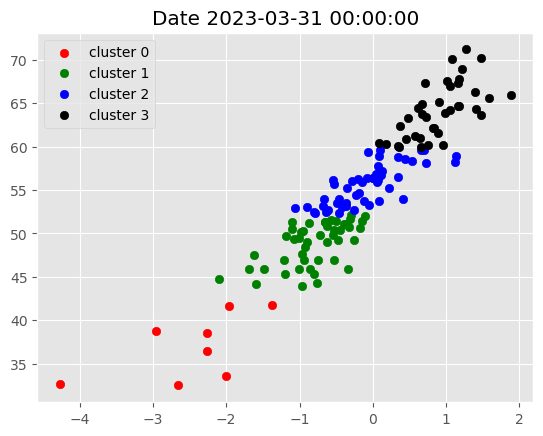

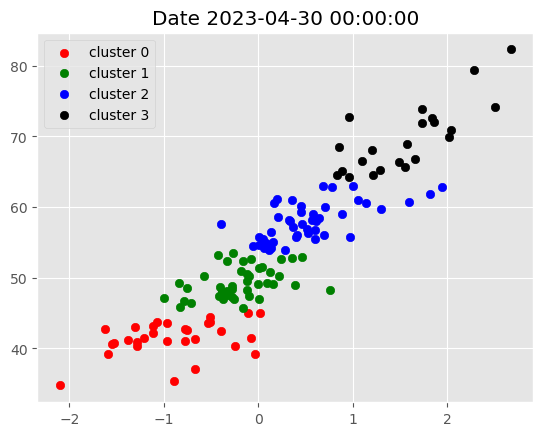

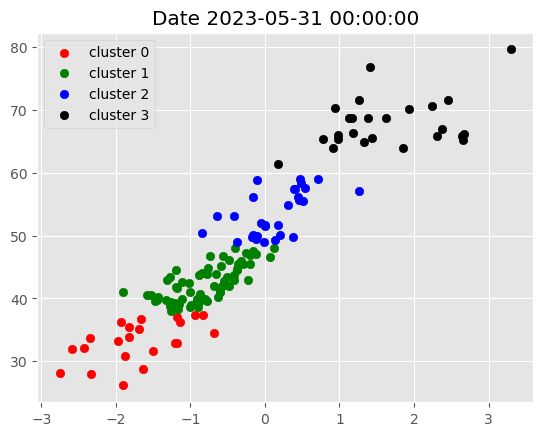

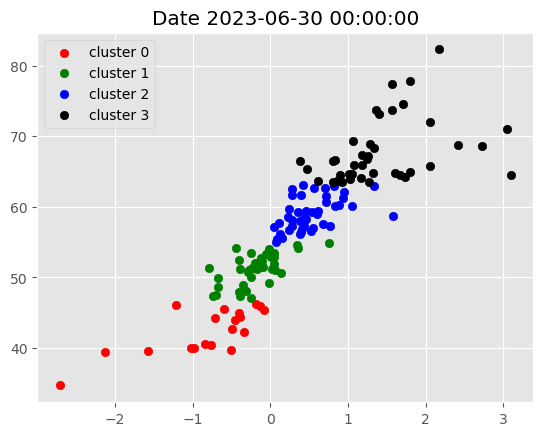

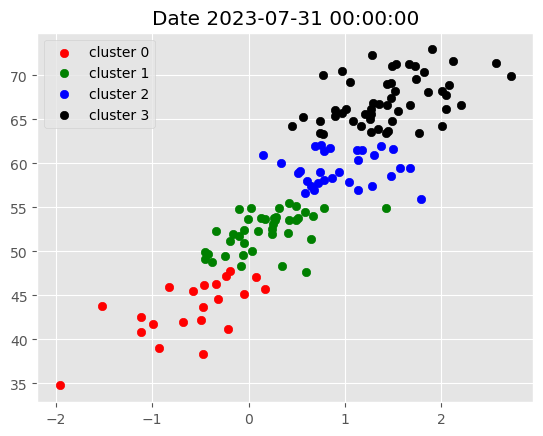

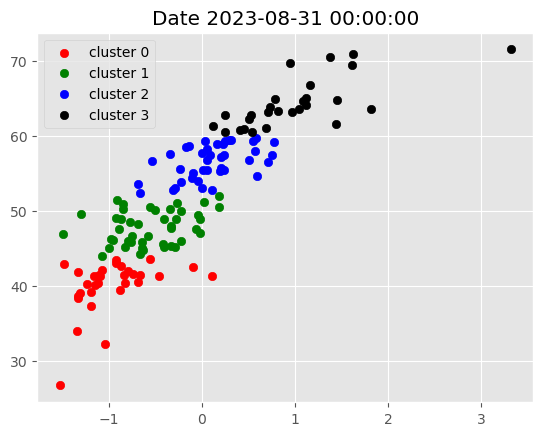

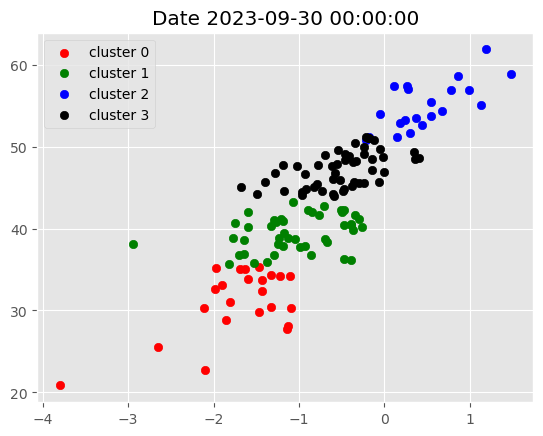

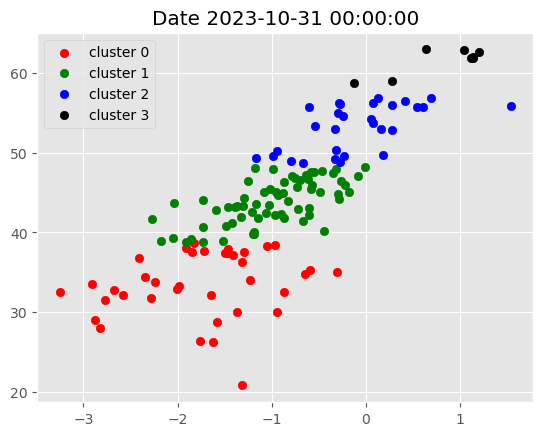

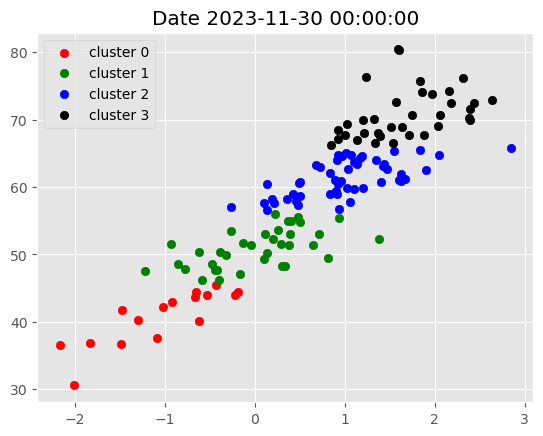

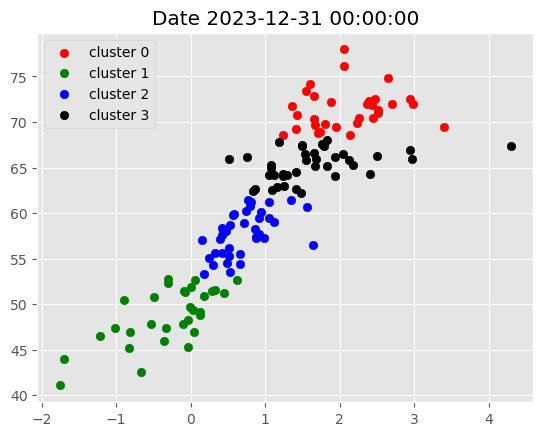

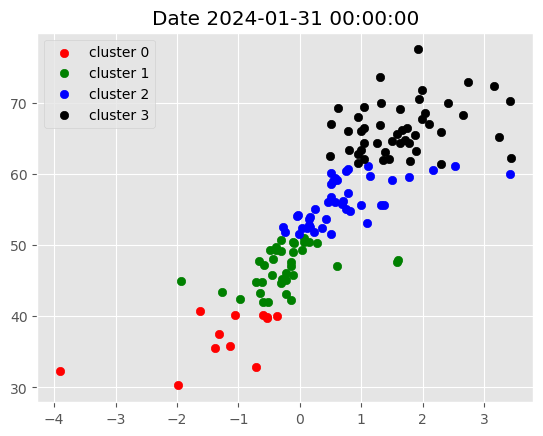

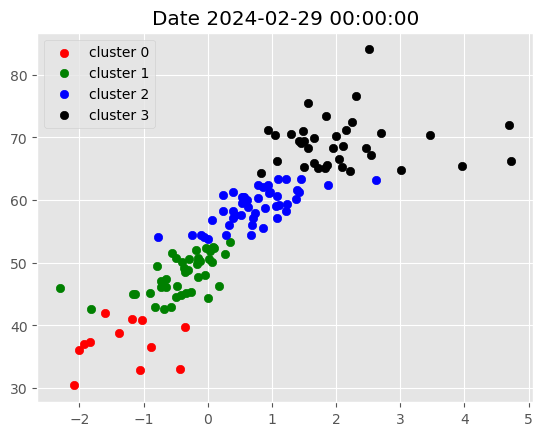

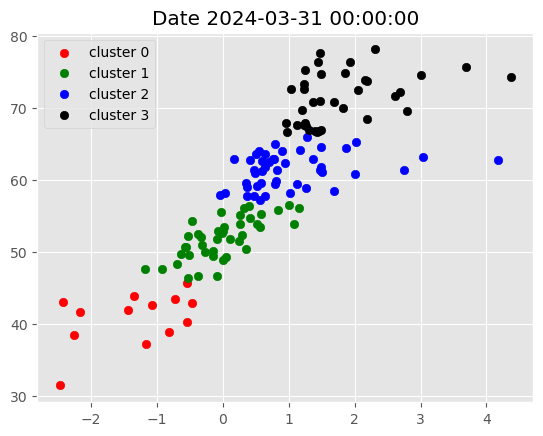

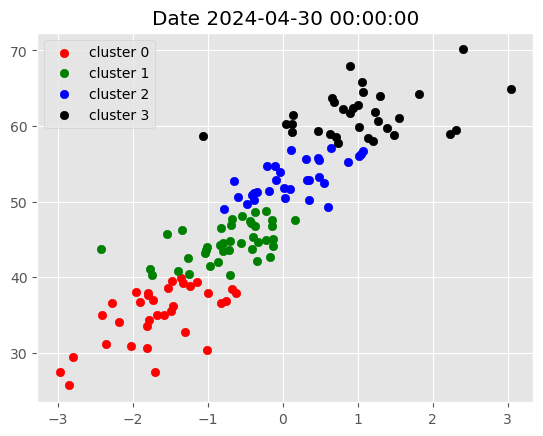

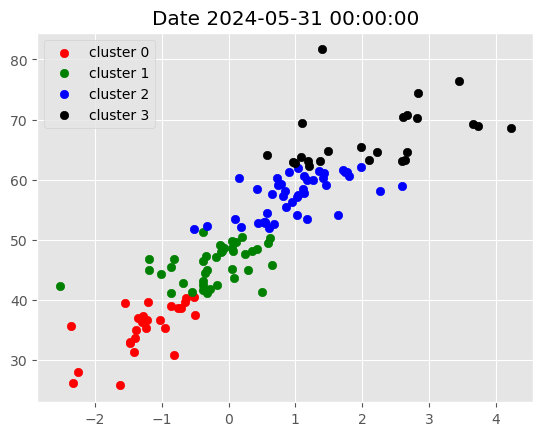

In [30]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### CLUSTER 3 Upward Momentum

In [31]:
## Based On Cluster 3, How to Form a Portfolio

In [32]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)
## Beginning of the next month

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-07-01': ['AMT',
  'BDX',
  'COST',
  'EA',
  'EOG',
  'KR',
  'NEE',
  'NFLX',
  'NKE',
  'PEP',
  'PG',
  'REGN',
  'SHW',
  'TJX'],
 '2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BDX',
  'BMY',
  'C',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',
  'ELV',
  'EOG',
  'EXPE',
  'GILD',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'LLY',
  'LMT',
  'LUV',
  'MDLZ',
  'MDT',
  'MMM',
  'MPC',
  'MRK',
  'ORLY',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'QCOM',
  'REGN',
  'RTX',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNP',
  'UPS',
  'USB',
  'VLO',
  'WMT'],
 '2018-09-01': ['AAPL',
  'ADP',
  'AMD',
  'AMZN',
  'BDX',
  'COST',
  'CSCO',
  'CVS',
  'DAL',
  'ISRG',
  'LLY',
  'LOW',
  'MDT',
  'ORLY',
  'QCOM',
  'REGN',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'V'],
 '2018-10-01': ['ABT',
  'ADP',
  'AMD',
  'AMGN',
  'AVGO',
  'CAT',
  'CI',
  'COP',
  'CSCO',
  'CVS',
  'DHR',
  'DIS',
  'ELV',
  'EOG',
  'HON',
  'ISRG',
  'LLY',
  'LMT',
  'LOW',
  'MA',
  'MDT',
  'MRK',
  'ORCL',


## Portfolio Maximization

In [37]:
!pip install PyPortfolioOpt


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.1 MB/s eta 0:00:00
  Created wheel for ecos: filename=ecos-2.0.14-cp311-cp311-macosx_11_0_arm64.whl size=72686 sha256=9b60b06221c41b8a6014c2fab77b4de400ad4c206864ce82ccf249e1a13c643f
  Stored in directory: /Users/shuaitaotan/Library/Caches/pip/wheels/8d/2c/50/ee2c49471cb896af40a1109297f6d62ff1296e446f8c59c67c
Successfully built ecos

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [38]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [39]:
## Pacakges may have version errors. Establish a New Environment can safely resolve the issue.

In [40]:
def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .25),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [42]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  154 of 155 completed

1 Failed download:
[*********************100%%**********************]  154 of 155 completed['AIG']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))


Price        Adj Close                                                  \
Ticker            AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2017-06-30   33.664436   52.464596   42.590477  110.406387  141.440002   
2017-07-03   33.542889   52.399487   42.678104  110.629532  138.410004   
2017-07-05   33.680801   52.442894   42.932182  110.736671  141.210007   
2017-07-06   33.362904   51.900227   42.003441  109.745811  140.750000   
2017-07-07   33.701836   52.117287   42.441513  110.879463  142.220001   
...                ...         ...         ...         ...         ...   
2024-05-23  186.663940  155.577042  103.193611  303.359406  483.309998   
2024-05-24  189.760345  154.397385  102.916382  298.460876  475.429993   
2024-05-28  189.770355  152.706543  100.936272  295.228302  478.429993   
2024-05-29  190.069992  152.165863   99.728409  291.301544  477.600006   
2024-05-30  191.068832  153.660095  100.728363  282.406952  445.869995   

Price                                                           ...   Volume  \
Ticker             ADI         ADP        ADSK AIG        ALGN  ...        V   
Date                                                            ...            
2017-06-30   67.747993   87.944366  100.820000 NaN  150.119995  ...  9036600   
2017-07-03   66.276360   87.910034   99.360001 NaN  149.029999  ...  6197700   
2017-07-05   67.695732   89.326286  102.599998 NaN  151.940002  ...  9339600   
2017-07-06   67.338715   88.785538  102.050003 NaN  149.740005  ...  8215700   
2017-07-07   68.331421   90.244682  103.320000 NaN  151.949997  ...  6175800   
...                ...         ...         ...  ..         ...  ...      ...   
2024-05-23  232.715424  248.791199  215.160004 NaN  252.389999  ...  6115900   
2024-05-24  230.681534  246.228989  214.889999 NaN  255.619995  ...  4339700   
2024-05-28  231.604248  240.689087  210.449997 NaN  253.770004  ...  6212100   
2024-05-29  226.355820  237.513535  208.509995 NaN  252.759995  ...  5469700   
2024-05-30  228.191284  238.324738  199.929993 NaN  256.500000  ...  4903100   

Price                                                                          \
Ticker          VLO     VRTX        VZ       WBA      WDC       WFC       WMT   
Date                                                                            
2017-06-30  2972000  1582300  13368900   7097300  6614900  16750700  20889900   
2017-07-03  2160000   825200   9732000   2419200  4562300  11825000  14545800   
2017-07-05  3938100  1320600  14853400   6481000  5119800  14086900  18110700   
2017-07-06  3332100  1171800  16854300   6011600  4143800  14481200  18485400   
2017-07-07  5083600  1019900  12198500   6001900  3436800  11503500  15921300   
...             ...      ...       ...       ...      ...       ...       ...   
2024-05-23  2251400  1554700  14105000  16012300  5393000  13056100  16222900   
2024-05-24  1794500  1050600  10418800  10541200  2743100   9912500  11793800   
2024-05-28  1912700  1379600  15071300  20137100  4779100  11276300  13349600   
2024-05-29  3774100   967300  17652000  21387700  7524500  12835000  11538600   
2024-05-30  3970100   975400  19636500  12134300  6287400  13584800  13053500   

Price                          
Ticker         WYNN       XOM  
Date                           
2017-06-30  1455000  14000600  
2017-07-03  2005600   8422300  
2017-07-05  1212300   9830800  
2017-07-06  1276900   9822400  
2017-07-07  1334800  10777800  
...             ...       ...  
2024-05-23  1465100  15979800  
2024-05-24  1035400  12211400  
2024-05-28  1812400  13978300  
2024-05-29  2367700  13902000  
2024-05-30  1219100  14692000  

[1740 rows x 930 columns]

In [45]:
import pandas as pd
import numpy as np
import yfinance as yf

# Define portfolio_df as an empty DataFrame before the loop
portfolio_df = pd.DataFrame()

stocks = data.index.get_level_values('ticker').unique().tolist()

# Download data for stocks
new_df = yf.download(
    tickers=stocks,
    start=data.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12),
    end=data.index.get_level_values('date').unique()[-1]
)

# Calculate returns dataframe
returns_dataframe = np.log(new_df['Adj Close']).diff()

# Loop through each start_date in fixed_dates
for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        try:
            weights = optimize_weights(prices=optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2), 4))
            weights = pd.DataFrame(weights, index=pd.Series(0))
            success = True

        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
            weights = pd.DataFrame(
                [1/len(optimization_df.columns) for _ in range(len(optimization_df.columns))],
                index=optimization_df.columns.tolist(),
                columns=pd.Series([0])
            ).T
            success = False

        temp_df = returns_dataframe[start_date:end_date]
        temp_df = (
            temp_df.stack()
            .to_frame('return')
            .reset_index(level=0)
            .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True), left_index=True, right_index=True)
            .reset_index()
            .set_index(['Date', 'Ticker'])
            .unstack()
            .stack()
        )

        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        # Append temp_df to portfolio_df
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

# Remove any duplicate entries in portfolio_df
portfolio_df = portfolio_df.drop_duplicates()
portfolio_df


[*********************100%%**********************]  155 of 155 completed

1 Failed download:
['MMM']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))


Max Sharpe Optimization failed for 2018-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2024-05-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2018-07-02,0.005611
2018-07-03,-0.006215
2018-07-05,0.008683
2018-07-06,0.011779
2018-07-09,0.000366
...,...
2024-05-23,-0.010218
2024-05-24,0.002926
2024-05-28,-0.004037


## Comparison & Visualization 

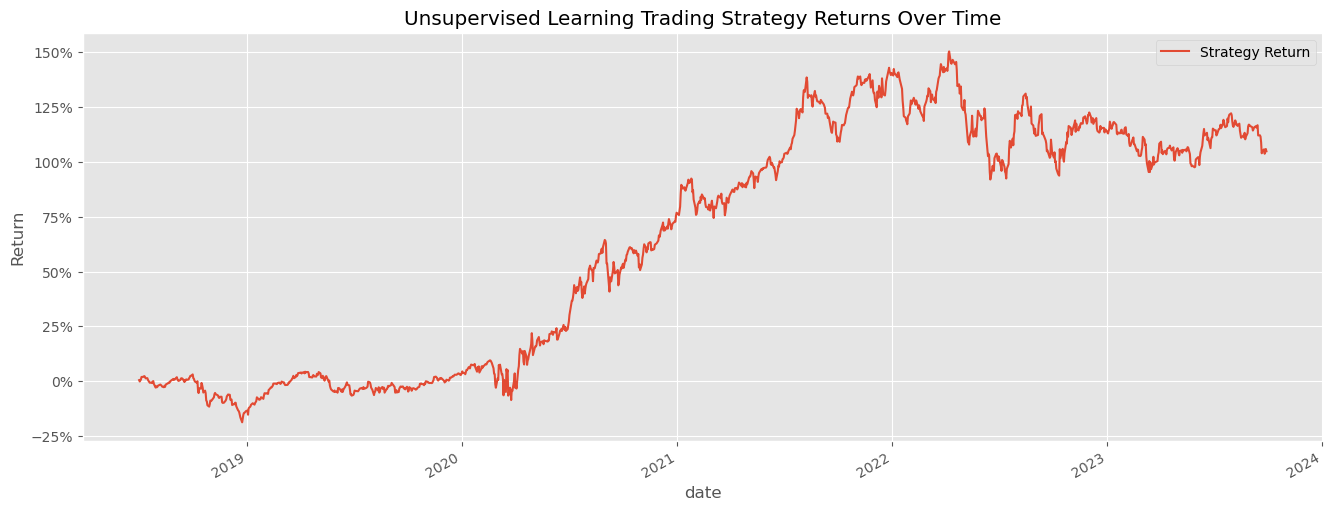

In [46]:
import matplotlib.ticker as mtick
import pandas as pd

plt.style.use('ggplot')

portfolio_df = portfolio_df.sort_index()  # Sort the DataFrame by the DatetimeIndex

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

nearest_date = pd.date_range(end='2023-09-29', periods=1, freq='D')[0]
portfolio_cumulative_return[:nearest_date].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

[*********************100%%**********************]  1 of 1 completed


<Figure size 1600x600 with 0 Axes>

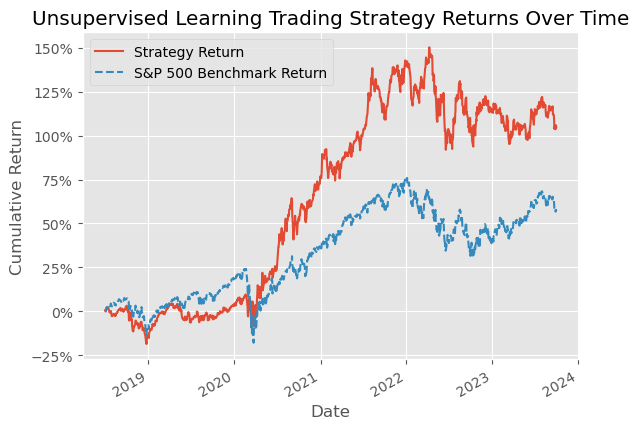

In [47]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# Ensure your portfolio DataFrame is sorted by date
portfolio_df = portfolio_df.sort_index()

# Calculate the cumulative return of your portfolio
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1

# Download S&P 500 historical data
sp500 = yf.download('^GSPC', start=portfolio_df.index.min(), end=portfolio_df.index.max())
sp500['Returns'] = sp500['Adj Close'].pct_change()
sp500_cumulative_return = np.exp(np.log1p(sp500['Returns']).cumsum()) - 1

# Plotting both cumulative returns
plt.figure(figsize=(16, 6))

# Portfolio cumulative return plot
portfolio_cumulative_return[:'2023-09-29'].plot(label='Portfolio Strategy Return')

# S&P 500 cumulative return plot
sp500_cumulative_return[:'2023-09-29'].plot(label='S&P 500 Benchmark Return', linestyle='--')

# Formatting the plot
plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


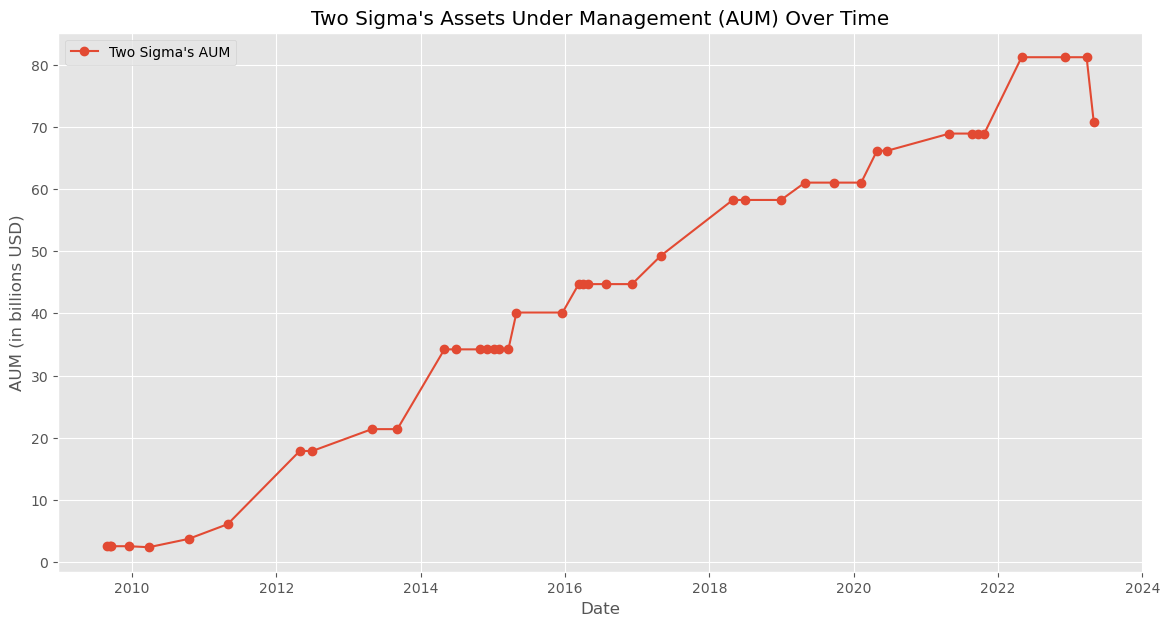

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for Two Sigma's AUM
data = {
    'Date': [
        '2009-08-28', '2009-08-28', '2009-09-09', '2009-09-17', '2009-12-14', '2010-03-26', '2010-10-13', 
        '2011-04-29', '2012-04-28', '2012-07-01', '2012-07-01', '2013-04-28', '2013-09-04', '2014-04-30', 
        '2014-06-29', '2014-10-28', '2014-12-01', '2015-01-05', '2015-02-03', '2015-03-20', '2015-04-30', 
        '2015-12-19', '2016-03-10', '2016-03-31', '2016-03-31', '2016-03-31', '2016-04-28', '2016-07-28', 
        '2016-12-05', '2017-04-30', '2018-04-29', '2018-06-30', '2018-12-29', '2019-04-29', '2019-09-25', 
        '2020-02-08', '2020-04-28', '2020-06-19', '2021-04-30', '2021-08-21', '2021-09-20', '2021-10-23', 
        '2022-04-30', '2022-12-04', '2023-03-25', '2023-04-30'
    ],
    'AUM': [
        2566488000, 2566488000, 2566488000, 2566488000, 2566488000, 2403696758, 3740232083, 6109062281, 
        17877451455, 17877451455, 17877451455, 21387025609, 21387025609, 34211524797, 34211524797, 
        34211524797, 34211524797, 34211524797, 34211524797, 34211524797, 40128805677, 40128805677, 
        44701962183, 44701962183, 44701962183, 44701962183, 44701962183, 44701962183, 44701962183, 
        49268746538, 58229500912, 58229500912, 58229500912, 61017039653, 61017039653, 61017039653, 
        66143308977, 66143308977, 68902797801, 68902797801, 68902797801, 68902797801, 81175371804, 
        81175371804, 81175371804, 70802799201
    ]
}

# Convert to DataFrame
aum_df = pd.DataFrame(data)
aum_df['Date'] = pd.to_datetime(aum_df['Date'])
aum_df = aum_df.drop_duplicates(subset='Date')  # Drop duplicate dates

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(aum_df['Date'], aum_df['AUM'] / 1e9, marker='o', label="Two Sigma's AUM")

plt.title("Two Sigma's Assets Under Management (AUM) Over Time")
plt.xlabel("Date")
plt.ylabel("AUM (in billions USD)")
plt.grid(True)
plt.legend()
plt.show()
